# Burger's Equation

$$
\int_{\Omega} \frac{\partial u}{\partial t} + (u . \nabla) u - \nu \nabla^2 u dx = 0
$$

$$
\equiv \int_{\Omega} \frac{\partial u}{\partial t} . v + ((u . \nabla) u).v + \nu (\nabla u. \nabla v) dx = 0
$$


In [45]:
import matplotlib.pyplot as plt

In [28]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
%matplotlib inline


NU = 0.0001


def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        dt = Constant(P.timesteps[index])
        nu = Constant(NU)

        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(dot(u, nabla_grad(u)), v) * dx
            + nu * inner(grad(u), grad(v)) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)

        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])

        # Define form
        F = mesh_seq.form(index, {"u": (u, u_)})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": VectorFunctionSpace(mesh, "CG", 1)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(mesh_seq[0])
    # An initial condition that propagates to both ends
    return {"u": interpolate(as_vector([sin(pi * (x - 0.5)), 0]), fs)}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        # ds(2) is dy (ds, subdomain 2)
        return inner(u, u) * ds(2)

    return end_time_qoi


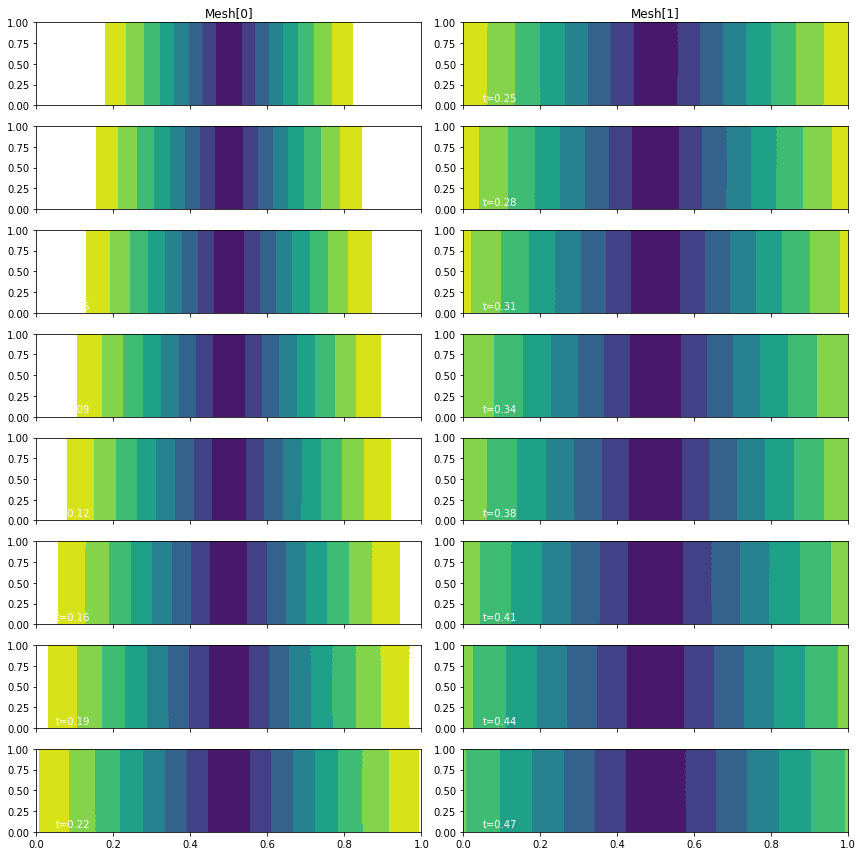

In [29]:
n = 32
fields = ["u"]
meshes = [
    UnitSquareMesh(n, n, diagonal="left"),
    UnitSquareMesh(n, n, diagonal="left"),
]
end_time = 0.5
dt = 1 / n
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions = mesh_seq.solve_forward()
fig, axes, tcs = plot_snapshots(solutions, time_partition, "u", "forward", levels=np.linspace(0, 0.8, 9))
# Note this is plotting the magnitude

In [30]:
solutions = mesh_seq.solve_adjoint()

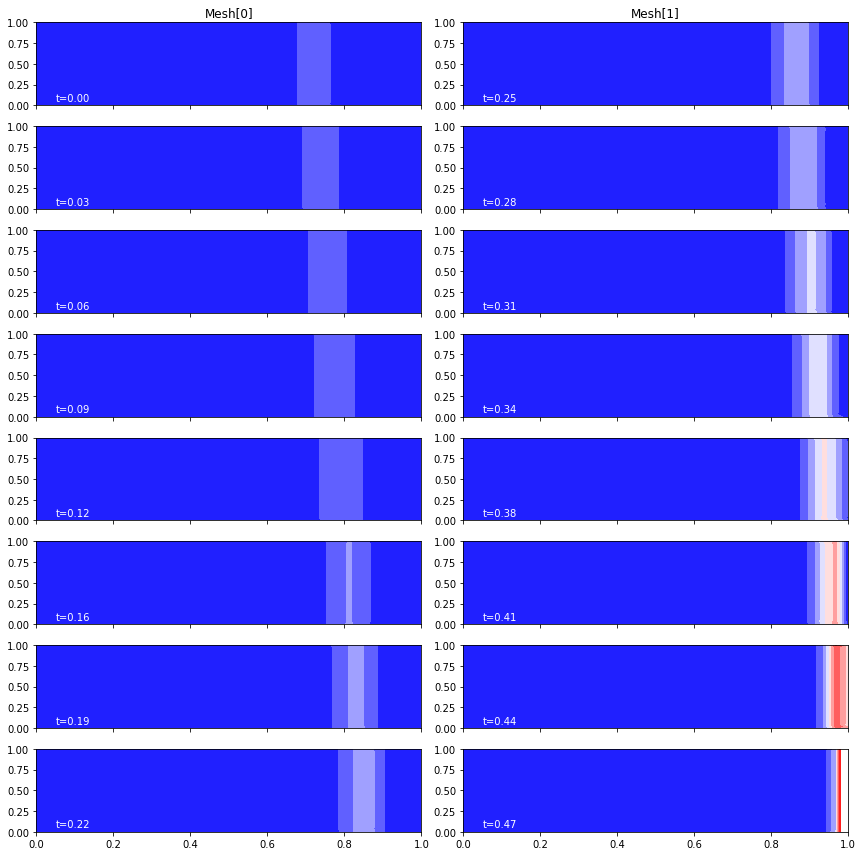

In [164]:
# print("QOI: {}".format(mesh_seq.get_qoi()))
fig, axes, tcs = plot_snapshots(
    solutions, time_partition, "u", "adjoint", levels=np.linspace(0, 0.8, 9), cmap='bwr'
)
fig.savefig("burgers2.jpg")

In [32]:
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

In [33]:
print(len(indicators[0]))
print(type(indicators))
print(len(indicators))
print(indicators[0][0].dat.data.shape)
print(mesh_seq[0].num_cells())
print(np.max(np.abs(indicators[0][7].dat.data)))
print(np.min(np.abs(indicators[0][7].dat.data)))
print("Machine epsilon for np.float32: {}".format(np.finfo(np.float32).eps))

8
<class 'list'>
2
(2048,)
2048
1.4003515796174025e-07
4.14834714124504e-22
Machine epsilon for np.float32: 1.1920928955078125e-07


8.179875766693569e-07 1.5227461348785536e-30


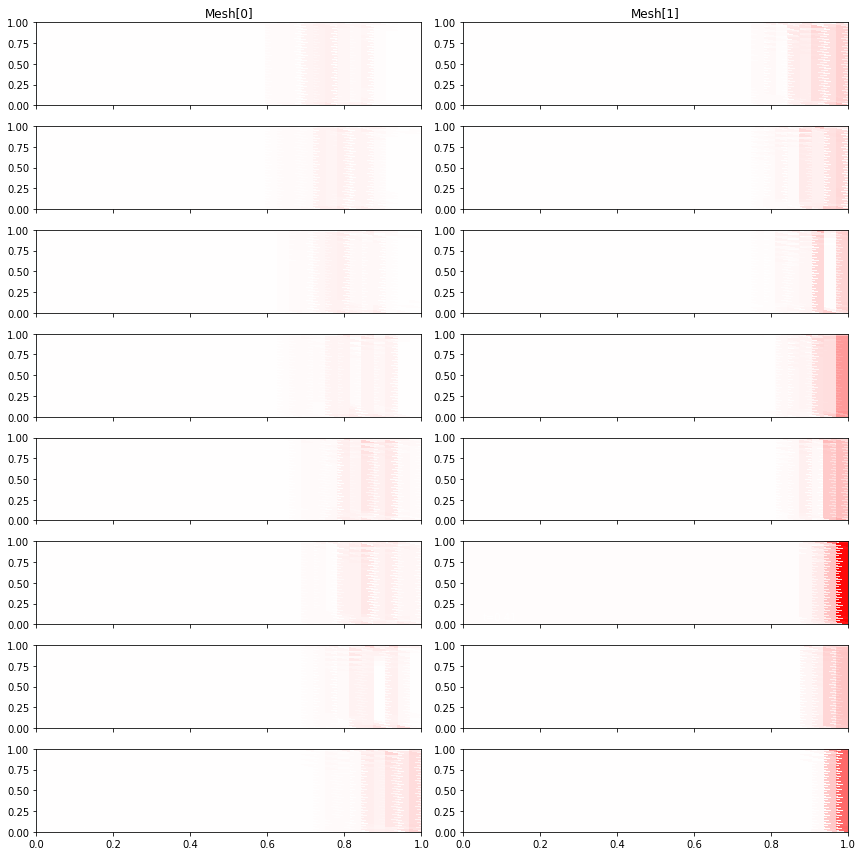

In [170]:
def plot_indicator_snapshots2(indicators, time_partition, **kwargs):
    """
    Plot a sequence of snapshots associated with
    ``indicators`` and :class:`TimePartition`
    ``time_partition``.

    Any keyword arguments are passed to ``tricontourf``.

    :arg indicators: list of list of indicators,
        indexed by mesh sequence index, then timestep
    :arg time_partition: the :class:`TimePartition`
        object used to solve the problem
    """
    P = time_partition
    rows = P.exports_per_subinterval[0] - 1
    cols = P.num_subintervals
    steady = rows == cols == 1
    figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    for i, indi_step in enumerate(indicators):
        ax = axes if steady else axes[0] if cols == 1 else axes[0, i]
        ax.set_title(f"Mesh[{i}]")
        tc = []
        for j, indi in enumerate(indi_step):
            ax = axes if steady else axes[j] if cols == 1 else axes[j, i]
            tc.append(tricontourf(indi, axes=ax, **kwargs))
            if not steady:
                time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

vmax, vmin = -np.inf, np.inf
for i, mesh_i in enumerate(indicators):
    for j, e_t in enumerate(indicators[i]):
        vmax = np.max((vmax, np.max(np.abs(e_t.dat.data))))
        vmin = np.min((vmin, np.min(np.abs(e_t.dat.data))))

print(vmax, vmin)
# We've switched over to a diverging colourmap, so for the bounds of our colourmap,
# we want the center of the range to be 0, so we go from 
# (vmax, vmin) to (-max(abs(vmax), abs(vmin)), max(abs(vmax), abs(vmin)))
fig, axs, tcs = plot_indicator_snapshots2(indicators, time_partition, 
                                          levels=50, vmax=max(abs(vmax), abs(vmin)), 
                                          vmin=-max(abs(vmax), abs(vmin)), cmap='bwr')

In [166]:
for field, sols in solutions.items():
    fwd_outfile = File(f"test_burgers2/{field}_forward.pvd")
    adj_outfile = File(f"test_burgers2/{field}_adjoint.pvd")
    for i, mesh in enumerate(mesh_seq):
        for sol in sols["forward"][i]:
            fwd_outfile.write(sol)
        for sol in sols["adjoint"][i]:
            adj_outfile.write(sol)

## Error indicators to a monitor function to mesh adaptation

To create a scalar monitor function, we need 2 assumptions - 
1. The error indicators are a good approximation *
2. The local errors $\epsilon$ are proportional to the square of local grid-length parameter $l$, i.e. $\epsilon = c l^2$ for some scalar constant $c > 0$. 

don't think this (1) IS a good assumption because our error is so low to begin with - might have to change something
We have verified that our indicators are essentially a P0 function, i.e. one that varies per cell. We need to then create this monitor function using some sort of regression / interpolation to solve for the best-fit value of $c$? Also, importantly, we probably have to smooth this function somewhat. The mesh can become really deformed and lose overall quality if we don't. 

In Bauer et al. [2014] they assume $\epsilon_{\text{est}} = c l^2_{\text{est}}$ where $l_{\text{est}}$ is the grid-length of the uniform un-adapted grid. In our problem we are trying to distribute the error globally across cells. By making errors across all cells even, we will be enforcing that the grid-length of cells in the more error-prone regions of the domain decreases as compared to those in regions that do not affect the QOI. Thus, we can pick some target error, and solve for $l^2_{\text{target}}$ in each cell to adapt it. So, an implementation can go cell-by-cell, and move the vertex-coordinates globally to achieve the target edge-length but probably shouldn't. I assume we can use a metric space also to do this. In keeping with ensuring good mesh quality we can use constraints as described in Bauer [2014] but we probably want to re-examine this. 


To actually achieve the r-adaptation, the paper describes a method that solves for the monitor function $f(x)$, such that $\int_{\Omega} f(x) dA(x) = 1$, with $c = C_{\text{norm}} > 0$ and ensuring that other constraints are met (e.g. grid duality constraint - centroids must lie inside the original cell). Now, we represent $f$ as a transformation of all the grid points' coordinates. Since $f$ represents a ratio of the new area of each element to the old area, it's essentially describing a determinant of some transformation of these grid points. Based on existing literature, if we have $f > 0$ in $\Omega$ and $\int_{\Omega} (f(x)-1)dA(x) = 0$, then this transformation exists and is given by 

$$\text{det} \nabla \phi (x, y) = f(x, y) \text{  in  } \Omega $$
and 
$$\phi (x, y) = (x, y)  \text { on } \Gamma = \partial \Omega$$

Once we've got to this point, there's a clever way to calculate $\phi$ as a system of ODEs

In [156]:
def plot_monitorfn_snapshots(monitor_fns, time_partition, **kwargs):
    """
    Plot a sequence of snapshots associated with
    ``monitor_fns`` and :class:`TimePartition`
    ``time_partition``.

    Any keyword arguments are passed to ``tricontourf``.

    :arg monitor_fns: list of list of monitor_fns,
        indexed by mesh sequence index, then timestep
    :arg time_partition: the :class:`TimePartition`
        object used to solve the problem
    """
    P = time_partition
    rows = 1
    cols = P.num_subintervals
    steady = rows == cols == 1
    figsize = kwargs.pop("figsize", (6 * cols, 3 * cols))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    for i, mesh_i in enumerate(monitor_fns):
        ax = axes if steady else axes[0] if cols == 1 else axes[i]
        ax.set_title(f"Mesh[{i}]")
        tc = []
        for j, fn in enumerate(monitor_fns[i]):
            ax = axes if steady else axes[j] if cols == 1 else axes[i]
            tc.append(tricontourf(fn, axes=ax, **kwargs))
            print(max(fn.dat.data))
            if not steady:
                time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

In [157]:
print(len(solutions['u']['adjoint']))
print(solutions['u']['adjoint'][0][0])

2
w_{8227}


### Idea : Time dependence of errors

$$
\mathbf{F}(\xi) \text{ or } \mathbf{F}(\xi, t)
$$

In Bauer [2014], they make the error indicators time-independent by picking the maximum error in each cell across each time step. This makes sense for a single adapted mesh, and the idea can be extended in a pretty straightforward way for our case. This way we can make our monitor function for each mesh be constant and compute a transformation from it using a PDE. We could also allow time-dependence of our monitor function as per Budd [2009].

If we are to make the error indicators now time-independent per mesh, we can do this by just picking the maximum error indicator in each cell across all time-steps relevant to each mesh. This gives us a time-independent error indicator for each mesh. The type of QOI (end-time or time-integrated) does not really impact this (I think). Below this is some code that picks the maximum error indicator for each cell in the mesh's assigned subinterval and plots the aggregated, time-independent error indicators for both meshes. 

What do we _expect_ to see? Essentially some sort of convolution / average of the earlier plots for the adjoints and error indicators. This is because the errors are weighted by the magnitude of the adjoint solution. For the second mesh, for the most part both non-zero regions of the adjoint and error indicators are towards the right boundary. However, from the plots, just before we swap meshes, there are non-zero error indicators toward the right boundary (even though adjoint weights are mostly around 0 there). Thus, the first mesh would have maximum errors from the center all the way to the right edge with varying magnitudes.

1.4003515796174025e-07 6.953927538955655e-17
8.179875766693569e-07 1.9467352308766235e-22
(2048,)
<bound method Function.function_space of Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe5a0a77400>, FiniteElement('Discontinuous Lagrange', triangle, 0), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3096)), 15946)>
1.4003515796174025e-07
8.179875766693569e-07


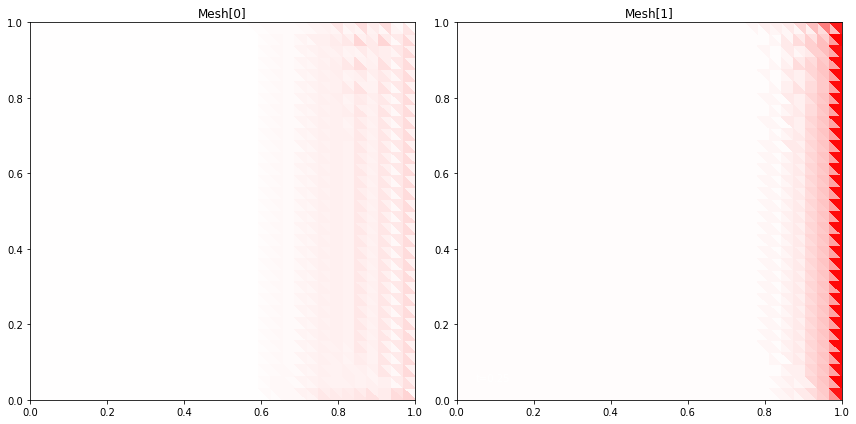

In [172]:
P0 = FunctionSpace(mesh, "DG", 0)
# For now, let's just plot indicator * adjoint solution
monitor_fns = []
areas = [get_areas2d(mesh) for mesh in mesh_seq]
vmax, vmin = -np.inf, np.inf
for i, mesh_i in enumerate(indicators):
    area = areas[i]
    
    max_errs = np.zeros(indicators[i][0].dat.data.shape)
    for j, e_t in enumerate(indicators[i]):
        max_errs = np.maximum(max_errs, e_t.dat.data)
        
    vmax = np.max((vmax, np.max(max_errs)))
    vmin = np.min((vmin, np.min(max_errs)))
    print(np.max(max_errs), np.min(max_errs))
    monitor_fn = Function(P0, val=max_errs)
    monitor_fns.append([monitor_fn])

test = monitor_fns[0][0]
print(test.dat.data.shape)
print(test.function_space)
fig, axs, tcs = plot_monitorfn_snapshots(monitor_fns, time_partition, 
                                         levels=50, cmap='bwr',
                                         vmax=max(abs(vmax), abs(vmin)),
                                         vmin=-max(abs(vmax), abs(vmin)))